<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential Regression

---
Antoine Savine, May 2021
---


This notebook illustrates <b> differential machine learning </b> in the simple context of linear regression. Differential ML was introduced in the October 2020 Risk article [Differential Machine Learning: the Shape of Things to Come](https://www.risk.net/cutting-edge/banking/7688441/differential-machine-learning-the-shape-of-things-to-come) by Brian Huge and Antoine Savine. Its main promise is the design of novel, more effective, ML algorithms based on the availability of <b> differential labels </b>. Classic datasets in machine learning include inputs $X\in\mathbb{R}^n$ and labels $Y \in \mathbb{R}$. Differential labels are defined as the gradients of labels $Y$ wrt inputs $X$:
    
        
$$Z^{\left(i\right)} \equiv \frac{\partial Y^{\left(i\right)}}{\partial X^{\left(i\right)}} \in \mathbb{R}^n$$
    
Differential labels are easily and efficiently computed with algorithmic adjoint differentiation (AAD) in some situations, like simulated datasets in finance.

Probably the simplest application of differential ML is a differential variant of linear regression. Recall that linear regression works with a fixed collection of basis functions of $X$:

$$\phi \left( X \right)\equiv \left[\phi_1\left(X\right), ..., \phi_K\left(X\right)\right]$$
    
This notebook implements polynomial regression, where the basis functions are all the monomials (also called polynomial features) of the form:

$$
    \phi_k\left(X\right) = \prod_{j=1}^{n} X_j^{p_j^k} \text{ with } \sum_{i=j}^n p_j^k \leq p 
$$

for a given degree $p$. The method is extended to arbitrary choices of basis functions in a straightforward manner. Note that the number $K$ of basis functions grows exponentially with dimension $n$, which is generally the case with linear regression. For this reason, linear regression is ineffective in high dimension and limited in practice to dimension lower than around $10$. More sophisticated ML models like neural networks are necessary in higher dimension, unless dimension is effectively reduced by adequate data pre-processing.

Linear regression approximates the target $Y$ with a linear combination of the basis functions $\phi$:

$$
    Y \approx \beta \cdot \phi\left(X\right)
$$

with weights $\beta$ found by minimization of the mean squared error: 

$$MSE = E\left\{\left[Y-\beta \cdot \phi\left(X\right)\right]^2\right\}$$ 

Zeroing the gradient of the MSE wrt weights we find the well-known normal equation:

$$
    \beta = C_{\phi\phi}^{-1} C_{\phi y}
$$

where $C_{\phi\phi} = E\left[\phi\left(X\right) \phi\left(X\right)^T\right] \in \mathbb{R}^{K \times K}$ and $C_{\phi y} = E\left[\phi\left(X\right) y\right] \in \mathbb{R}^K$ are estimated on the training set.

A more stable and effective form of regression is obtained by Tikhonov regularization, which penalizes large weights to mitigate overfitting, so as to minimize the modified cost function:

$$
    \min \left\{ MSE + \alpha \left\Vert \beta \right \Vert ^2 \right\}
$$

leading to the modified normal equation:

$$
    \beta = \left(C_{\phi\phi} + \alpha I_K\right)^{-1} C_{\phi y}
$$

Tikhonov regularization (also called ridge regression) is known to effectively regularize linear regression but considerably depend on regularization strength $\alpha$. Ridge regression reverts to standard regression with small $\alpha$, hence failing to mitigate overfitting, and converges to a horizontal line with large $\alpha$, a phenomenon known as underfitting. Because Tikhonov regularization trades variance for bias, a sweet spot must be found, generally by cross-validation. Therefore, ridge regression is not a simple, zero-cost drop-in replacement for linear regression.

Given the availability of differential labels $Z$, <b> differential regression </b> minimizes a combination of value and derivatives errors:
    
$$
    \min \left\{ MSE + \sum_{j=1}^n \alpha_j   E\left\{\left[Z_j-\beta \cdot \phi_j\left(X\right)\right]^2\right\} \right\}
$$

where $\phi_j\left(X\right) = \left[\frac{\partial \phi_1\left(X\right)}{\partial X_j}, ...,  \frac{\partial \phi_K\left(X\right)}{\partial X_j}\right] \in \mathbb{R}^K$ is the vector of partial derivatives of the basis functions wrt the j-th input $X_j$, and $Z_j$ is the j-th differential label.

Zeroing the gradient of the differential objective wrt weights $\beta$, we obtain the differential normal equation:

$$
    \beta = \left( C_{\phi\phi} + \sum_{j=1}^n \alpha_j C_{jj}^\phi \right)^{-1} \left( C_{\phi y} + \sum_{j=1}^n \alpha_j C_{jy}^\phi \right)
$$

where $C_{jj}^\phi = E\left[\phi_j\left(X\right) \phi_j\left(X\right)^T\right] \in \mathbb{R}^{K \times K}$ and $C_{j y}^\phi = E\left[\phi_j\left(X\right) y\right] \in \mathbb{R}^K$.

Similarly to ridge regression, the hyperparameters $\alpha_j$ control the relative importance of derivatives correctness in the minimization objective. Contrarily to ridge regression, however, differential regularization does not introduce bias. It follows that it has little risk of underfitting. A reasonable default is given by:

$$
    \alpha_j = \frac{E\left[Y^2\right]}{E\left[Z_j^2\right]}
$$

and doesn't generally require manual tinkering or cross-validation. It follows that, in addition to being much more effective as we will see, differential regression is a simple drop-in replacement for classic regression. Its effectiveness hinges on differential labels, which may or may not be cheaply available in a given situation. In the context of computed or simulated datasets, differential labels are always efficiently computed with AAD. 

# Imports

In [2]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

if 'google.colab' in str(get_ipython()):
    colab = True
    mpl.rc('animation', html='jshtml')
    print('Running on CoLab')
else:
    colab = False
    print('Not running on CoLab')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

Not running on CoLab


# Implementation

Classic polynomial regression is trivially implemented by piping polynomial features with linear regression in scikit-learn.

In [3]:
def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

A factory function for ridge regression is implemented in an identical manner. Conveniently, scikit-learn has a variant with cross-validation built-in.

In [4]:
# ridge regression with builtin cross-validation
def make_ridge(degree=5, alpha=1.0): # alpha = regularization strength, usually denoted lambda
    return make_pipeline(PolynomialFeatures(degree=degree), Ridge(alpha=alpha, normalize=True))

# ridge regression with builtin cross-validation
def make_ridge_cv(degree=5, min_alpha=1e-05, max_alpha=1e02, num_alphas=100): 
    alphas = np.exp(np.linspace(np.log(min_alpha), np.log(max_alpha), num_alphas))
    return make_pipeline(PolynomialFeatures(degree=degree), RidgeCV(alphas=alphas, normalize=True))

Differential regression requires a custom implementation of the equations given in the introduction. The code may be hard to read at first sight because the equations are efficiently implemented with numpy's vectorized primitives. This implementation otherwise directly reflects the equations. 

In [5]:
eps = 1.0e-8
class DifferentialRegression:
    
    def __init__(self, degree=5, alpha=1.0):
        self.degree = degree
        self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
        self.alpha = alpha
    
    def fit(self, x, y, z):     
        self.phi_ = self.polynomial_features.fit_transform(x)
        self.powers_ = self.polynomial_features.powers_
        
        self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
                
        self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1,1,-1)
        self.dphiw_ = self.dphi_ * self.lamj_
        
        phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0,2],[0,2]))
        phiTz = np.tensordot(self.dphiw_, z, axes=([0,2],[0,1])).reshape(-1,1)
        
        inv = np.linalg.inv(self.phi_.T @ self.phi_ + self.alpha * phiTphi)
        self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)
        
    def predict(self, x, predict_derivs=False):
        phi = self.polynomial_features.transform(x)
        y_pred = phi @ self.beta_
        
        if predict_derivs:
            dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
            z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
            return y_pred, z_pred
        else:
            return y_pred

# Black & Scholes dataset

We illustrate the performance of differential regression with two simulated datasets: the one-dimensional European call in the lognormal Black & Scholes model, and the multi-dimensional basket option in the Gaussian Bachelier model. In both cases, we learn the pricing function $v\left(X\right)$ from examples of initial states $X$ labeled by simulated payoffs $Y$ and pathwise differentials $Z$ and compare to known ground truth on independent test sets.  

Note that prices are not learned from examples of prices but from examples of payoffs, whereby each training example consists in one payoff sampled with the simulation model. The computational cost of one example is therefore the cost of simulating one Monte-Carlo path, so the entire dataset is generated for a cost similar to one pricing by Monte-Carlo. The pathwise differentials are easily computed by instrumenting the path simulation with AAD. In the simple examples presented here, pathwise differentials are computed analytically.

The pricing formula is only implemented for reference, so we easily measure the out-of-sample performance of the fit.

In [6]:
def BlackScholes(S, K, sigma, T):
    d1 = (np.log(S/K) + sigma * sigma * T) / sigma / np.sqrt(T)
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * norm.cdf(d2)

def BlackScholesDelta(S, K, sigma, T):
    d1 = (np.log(S/K) + sigma * sigma * T) / sigma / np.sqrt(T)
    return norm.cdf(d1)

class BlackScholesSimulator():
    def __init__(self, sigma, K, T, lower=10, upper=200):
        self.sigma = sigma
        self.sigma2 = sigma * sigma
        self.K = K
        self.T = T
        self.sqrtT = np.sqrt(T)
        self.lower = lower
        self.upper = upper
        
    def trainSet(self, m, seed=0):
        s0 = np.linspace(self.lower, self.upper, m)
        
        np.random.seed(seed)
        wT = np.random.normal(size=m)
        sT = s0 * np.exp(-0.5 * self.sigma2 * self.T + self.sigma * self.sqrtT * wT)
        pay = np.maximum(0, sT - self.K)
        deriv = np.where(sT > self.K, sT / s0, 0)
        
        return s0.reshape(-1, 1), pay.reshape(-1, 1), deriv.reshape(-1, 1)
    
    def testSet(self, m):
        s0 = np.linspace(self.lower, self.upper, m)
        val = BlackScholes(s0, self.K, self.sigma, self.T)
        delta = BlackScholesDelta(s0, self.K, self.sigma, self.T)
        return s0.reshape(-1, 1), val.reshape(-1, 1), delta.reshape(-1, 1)

We learn Black & Scholes pricing by regression over 200 evenly spaced examples. We purposely train on a small dataset to highlight overfitting and dependency on noise. Readers can easily increase the size of the dataset (variable m below) to confim convergence.

In [7]:
# parameters and constants

sigma = 0.2
K = 110
T = 2

m = 200       # size of train set
M = 5000      # size of test set
lower = 10
upper = 200

seed = np.random.randint(8192)
print("using seed", seed)

using seed 4624


In [8]:
# simulate dataset

bs = BlackScholesSimulator(sigma, K, T, lower, upper)
x_train, y_train, z_train = bs.trainSet(m, seed=seed)
x_test, y_test, z_test = bs.testSet(M)

In [9]:
# learn and predict

linreg = make_polynomial()
linreg.fit(x_train, y_train)
linpred = linreg.predict(x_test)

ridgereg = make_ridge_cv()
ridgereg.fit(x_train, y_train)
ridgepred = ridgereg.predict(x_test)
alpha = ridgereg['ridgecv'].alpha_

diffreg = DifferentialRegression()
diffreg.fit(x_train, y_train, z_train)
diffpred = diffreg.predict(x_test)

<IPython.core.display.Javascript object>


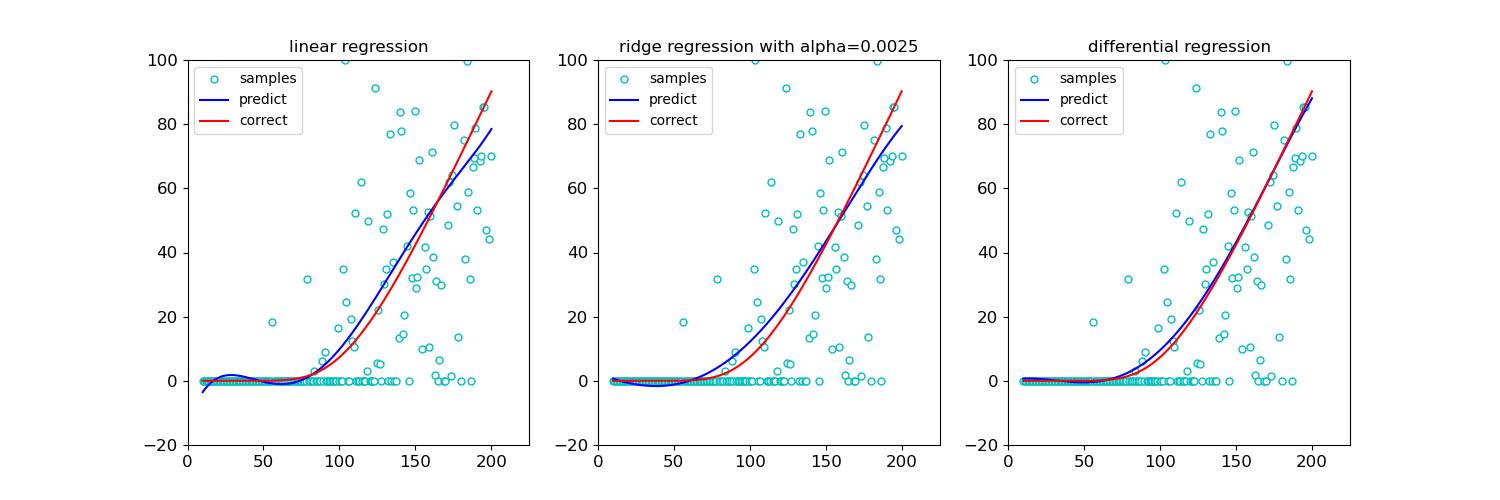

In [10]:
# plot results

def plot_one(ax, x_train, y_train, x_test, y_test, pred):
    ax.set_xlim(0, 225)
    ax.set_ylim(-20, 100)
    samples, = ax.plot(x_train, y_train, 'co', markersize=5, markerfacecolor="white", label="samples")
    predict, = ax.plot(x_test, pred, 'b-', label="predict")
    correct, = ax.plot(x_test, y_test, 'r-', label="correct")
    return samples, predict, correct

def plot_multi(x_train, y_train, x_test, y_test, titles, preds):
    nplots = len(preds)
    nrows = (nplots - 1) // 3 + 1
    ncols = min(nplots, 3)
    
    fig, axs = plt.subplots(nrows, ncols, squeeze=False)
    fig.set_size_inches(ncols * 5, nrows * 5)

    lines = []
    for i, ax in enumerate(axs.flatten()):
        if i < nplots:
            samples, predict, correct = plot_one(ax, x_train, y_train, x_test, y_test, preds[i])
            lines.extend([samples, predict, correct])
            ax.legend()
            ax.set_title(titles[i])
    
    return fig, lines
            
_, _ = plot_multi(x_train, y_train, x_test, y_test, 
           ["linear regression", "ridge regression with alpha=%.4f" % alpha, "differential regression"],
           [linpred, ridgepred, diffpred])

To better appreciate overfitting and stabilization by ridge or differentials, we repeatedly learn from independently simulated datasets and animate. <b> This cell may take about 10 seconds to render the animation on Google colab </b>.

<IPython.core.display.Javascript object>


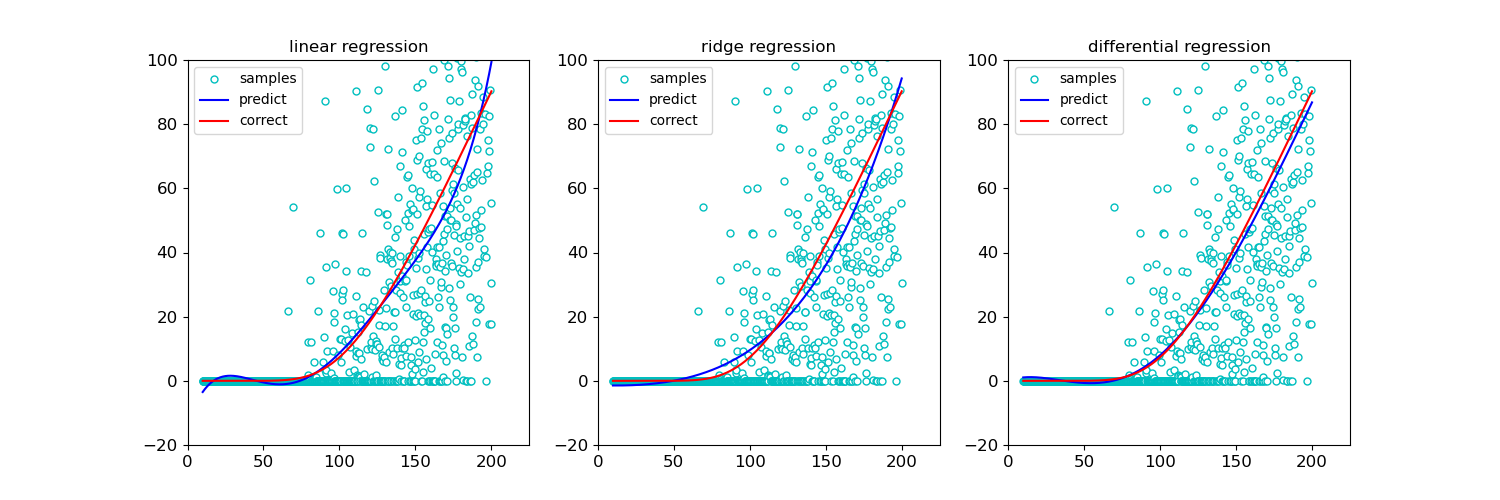

In [12]:
fig, lines = plot_multi(x_train, y_train, x_test, y_test, 
           ["linear regression", "ridge regression", "differential regression"],
           [linpred, ridgepred, diffpred])

def animate(i):
    seed = np.random.randint(8192)
    x_train, y_train, z_train = bs.trainSet(m, seed=seed)
    
    linreg.fit(x_train, y_train)
    linpred = linreg.predict(x_test)
    ridgereg.fit(x_train, y_train)
    ridgepred = ridgereg.predict(x_test)
    diffreg.fit(x_train, y_train, z_train)
    diffpred = diffreg.predict(x_test)
    
    lines[0].set_data(x_train, y_train)
    lines[1].set_data(x_test, linpred)
    lines[3].set_data(x_train, y_train)
    lines[4].set_data(x_test, ridgepred)
    lines[6].set_data(x_train, y_train)
    lines[7].set_data(x_test, diffpred)
    
    return lines

# slow on colab
FuncAnimation(fig, animate, frames=20 if colab else 200, interval=500, blit=True)

Classic regression overfits, as illustrated by the wigly shape of its predictions, which also vary significantly in response to the noise in the dataset, a phenomenon known as variance. Cross-validated Tikhonov regularization clearly stabilizes regression, in return for a bias whereby the model struggles to match the correct shape. The results of differential regression, by contrast, appear to be consistently correct (given the small dataset) with much lower variance.

# Bachelier basket dataset

The Black & Scholes dataset is one-dimensional, contrarily to most real-world problems in finance, where the market state that affects the price and risk of Derivatives transactions and trading books is typically high-dimensional. To illustrate differential regression in the context of an equally simple but higher dimension example, we consider basket options in the correlated Gaussian Bachelier model. The simulation of the dataset is essentially a carbon-copy of the Black & Scholes simulator. This example is also interesting because the price and risks of a basket option only depend on the initial price of the underlying basket under the Gaussian assumption, irrespective of single stocks. This is therefore a single-dimensional problem, but of course, the fitting algorithm is unaware of this fact and treats the dataset as multi-dimensional. We can, however, conveniently visualize results with two-dimensional graphs where the horizontal axis is indexed by the initial basket.

First, we have Bachelier analytics that provide the correct pricing function to easily measure performance.

In [13]:
def Bachelier(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return  sigma * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def BachelierDelta(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return norm.cdf(d)

Next, we use helper functions to generate random correlation matrices, basket weights and volatilities, so we can easily test the methods in different circumstances without dealing with real market data.

In [14]:
# generates a random correlation matrix
def genCorrel(n):
    randoms = np.random.uniform(low=-1., high=1., size=(2*n, n))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])

# generates random weights
def genWeights(n):
    w = np.random.uniform(size=n)
    return w / w.sum()

# generates random volatilities such that the volatility of the basket matches a given target
def genVols(n, correl, weights, bkt_vol=20):
    vols = np.random.uniform(size=n)
    weighted_vols = (weights * vols).reshape(-1,1)
    v = np.sqrt(np.linalg.multi_dot([weighted_vols.T, correl, weighted_vols]).reshape(1))
    vols = vols * bkt_vol / v
    return vols

Finally, we have a simulator very similar to Black & Scholes.

In [15]:
class BachelierSimulator():
    
    # None = generate randomly
    def __init__(self, n, T, K, vols=None, correl=None, weights=None, bkt_vol=20, seed=0, lower=10, upper=200):
        self.n = n
        self.T = T
        self.sqrtT = np.sqrt(T)
        self.K = K
        
        np.random.seed(seed)
        self.weights = genWeights(n) if weights is None else weights
        self.correl = genCorrel(n) if correl is None else correl
        self.vols = genVols(n, self.correl, self.weights, bkt_vol) if vols is None else vols
        self.bkt_vol = bkt_vol
        
        vT = np.diag(self.vols) * self.sqrtT
        self.cov = np.linalg.multi_dot([vT, self.correl, vT])
        self.chol = np.linalg.cholesky(self.cov) 
        
        self.lower = lower
        self.upper = upper
        
    def trainSet(self, m, seed=0):
        np.random.seed(seed)

        s0 = np.random.uniform(low=self.lower, high=self.upper, size = (m, self.n))
        b0 = np.dot(s0, self.weights)
        wT = np.random.normal(size=(m, self.n))
        sT = s0 + wT @ self.chol.T
        bT = np.dot(sT, self.weights)
        pay = np.maximum(0, bT - self.K)
        deriv = np.where(bT > self.K, 1, 0).reshape(-1, 1) * self.weights.reshape(1, -1)
        
        return s0.reshape(-1, self.n), b0.reshape(-1, 1), pay.reshape(-1, 1), deriv.reshape(-1, self.n)
    
    def testSet(self, m, seed=1024): # must be a different seed
        np.random.seed(seed)
        
        s0 = np.random.uniform(low=self.lower, high=self.upper, size = (m, self.n))
        b0 = np.dot(s0, self.weights).reshape((-1, 1))
        prices = Bachelier(b0, self.K, self.bkt_vol, self.T)
        deltas = BachelierDelta(b0, self.K, self.bkt_vol, self.T) @ self.weights.reshape((1, -1))
        return s0, b0, prices.reshape(-1, 1), deltas.reshape(-1, self.n)    

We now have all the pieces we need to learn basket option prices.

In [16]:
# dimension, readers are encouraged to play with different dimensions by changing the value of n
n = 3

In [17]:
# parameters and constants

# basket volatility is fixed but the volatilities of single stocks are randomly generated
bkt_vol = 20
K = 110
T = 2

# we need a larger dataset in higher dimension, at least 1,000 examples
m = 1000
M = 5000
lower = 10
upper = 200

# generate random correlation, weights and volatility
seed = np.random.randint(8192)
correl = genCorrel(n)
weights = genWeights(n)
vols = genVols(n, correl, weights, bkt_vol)

# re-seed for dataset
seed = np.random.randint(8192)
print("using seed", seed)

using seed 7638


In [18]:
# simulate dataset

bach = BachelierSimulator(n, T, K, vols, correl, weights, bkt_vol, seed)
x_train, bkt_train, y_train, z_train = bach.trainSet(m, seed=seed)
x_test, bkt_test, y_test, z_test = bach.testSet(M)

In [19]:
# learn and predict

#linreg = make_polynomial()
#linreg.fit(x_train, y_train)
#linpred = linreg.predict(x_test)

# linear regression is numerically unstable with nearly colinear features
# normally, this is resolved by SVD inversion in the normal equation
# since SVD is not implemented in the linear regression of scikit-learn
# we use a ridge regression with small alpha as a walkaround

linreg = make_ridge(alpha=1.0e-04)
linreg.fit(x_train, y_train)
linpred = linreg.predict(x_test)

ridgereg = make_ridge_cv()
ridgereg.fit(x_train, y_train)
ridgepred = ridgereg.predict(x_test)
alpha = ridgereg['ridgecv'].alpha_

diffreg = DifferentialRegression()
diffreg.fit(x_train, y_train, z_train)
diffpred = diffreg.predict(x_test)

<IPython.core.display.Javascript object>


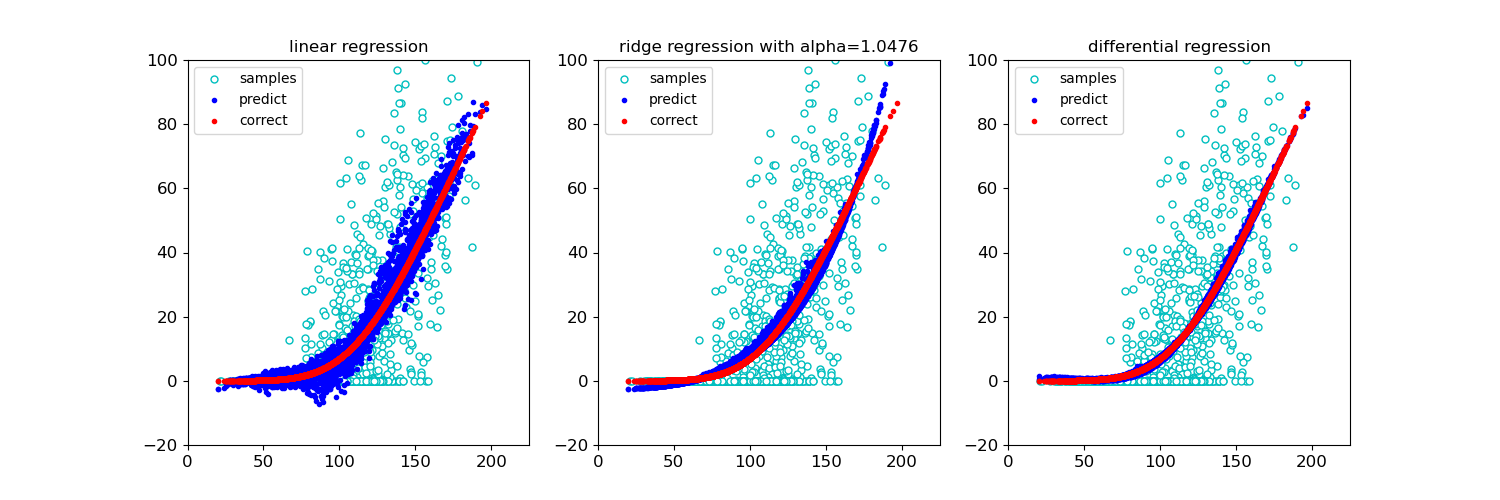

In [20]:
# plot results

def plot_one(ax, bkt_train, y_train, bkt_test, y_test, pred):
    ax.set_xlim(0, 225)
    ax.set_ylim(-20, 100)
    samples, = ax.plot(bkt_train, y_train, 'co', markersize=5, markerfacecolor="white", label="samples")
    predict, = ax.plot(bkt_test, pred, 'b.', label="predict")
    correct, = ax.plot(bkt_test, y_test, 'r.', label="correct")
    return samples, predict, correct

def plot_multi(bkt_train, y_train, bkt_test, y_test, titles, preds):
    nplots = len(preds)
    nrows = (nplots - 1) // 3 + 1
    ncols = min(nplots, 3)
    
    fig, axs = plt.subplots(nrows, ncols, squeeze=False)
    fig.set_size_inches(ncols * 5, nrows * 5)

    lines = []
    for i, ax in enumerate(axs.flatten()):
        if i < nplots:
            samples, predict, correct = plot_one(ax, bkt_train, y_train, bkt_test, y_test, preds[i])
            lines.extend([samples, predict, correct])
            ax.legend()
            ax.set_title(titles[i])
    
    return fig, lines
            
_, _ = plot_multi(bkt_train, y_train, bkt_test, y_test, 
           ["linear regression", "ridge regression with alpha=%.4f" % alpha, "differential regression"],
           [linpred, ridgepred, diffpred])

And animate (allowing about 10 seconds for rendering on colab):

<IPython.core.display.Javascript object>


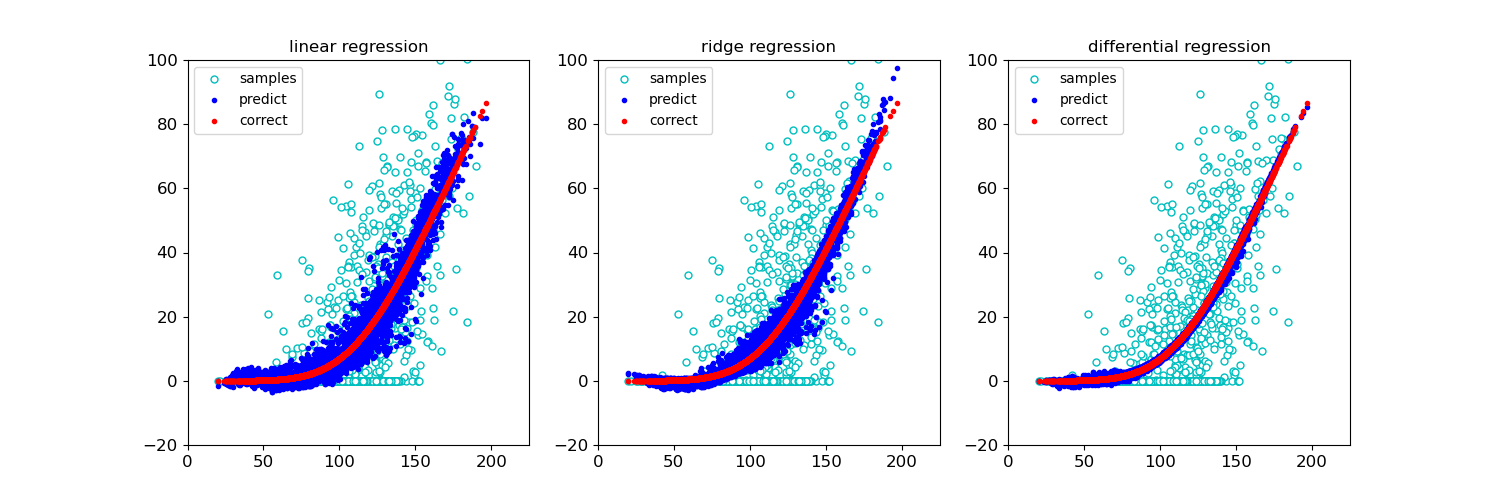

In [21]:
fig, lines = plot_multi(bkt_train, y_train, bkt_test, y_test, 
           ["linear regression", "ridge regression", "differential regression"],
           [linpred, ridgepred, diffpred])

def animate(i):
    seed = np.random.randint(8192)
    
    x_train, bkt_train, y_train, z_train = bach.trainSet(m, seed=seed)
    
    linreg.fit(x_train, y_train)
    linpred = linreg.predict(x_test)
    ridgereg.fit(x_train, y_train)
    ridgepred = ridgereg.predict(x_test)
    diffreg.fit(x_train, y_train, z_train)
    diffpred = diffreg.predict(x_test)
    
    lines[0].set_data(bkt_train, y_train)
    lines[1].set_data(bkt_test, linpred)
    lines[3].set_data(bkt_train, y_train)
    lines[4].set_data(bkt_test, ridgepred)
    lines[6].set_data(bkt_train, y_train)
    lines[7].set_data(bkt_test, diffpred)
    
    return lines

# slow on colab
FuncAnimation(fig, animate, frames=20 if colab else 200, interval=500, blit=True)

Differential regression shines in higher dimension 3 to 7. Above dimension 7 to 10, however, all forms of linear regression become very slow, and rapidly fill computer memory. Linear regression is not effective in high dimension, and differential regularization does not provide a silver bullet. It gives a sharp improvement over classic regression and well-known forms of regularization. But its applicability remains limited to dimension under about 10. 

In real-world applications in finance, where dimension routinely stands in the hundreds, linear regression, differential or otherwise, is only possible when coupled with effective dimension reduction. Dimension reduction is not only strictly necessary for linear regression, it also facilitates, stabilizes and speeds-up more sophisticated ML models like neural networks. It is a recommended pre-processing step in all circumstances.

Classic dimension reduction algorithms like principal components analysis (PCA) are however unsafe, prone to truncate subspaces of little variation, which may still affect prices and risk in a substantial manner. By contrast, <b> differential PCA </b>, developed as a part of the differential ML ecosystem, provides a safe and effective dimension reduction, once again, leveraging differential labels. In the basket example, differential PCA univoquely identifies the underlying basket as the only relevant regression feature, safely reducing dimension to one. Differential PCA is covered in the upcoming article <b> Axes that matter: PCA with a difference </b>.